### Input Proper Libraries 

In [1]:
import pandas as pd
import re
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


2024-03-23 09:53:33.120708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pre-Process the Data

In [3]:
# Load the data
df = pd.read_csv('/Users/sveerisetti/Desktop/Duke_Spring/Deep_Learning/Projects/Project_2/Data/raw_data.csv')
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Function to strip tweet related characters
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split())

# Apply the function to the 'tweet' column if CLEAN_TWEETS is False
CLEAN_TWEETS = False
if not CLEAN_TWEETS:
    df['tweet'] = df['tweet'].apply(strip_all_entities)


# Now we want to combine classes 0 and 1 into class 0, rename class 2 to class 1
df['class'] = df['class'].replace(1, 0)
df['class'] = df['class'].replace(2, 1)

# Save the modified DataFrame to a new CSV file
df.to_csv('cleaned_labeled_data.csv', index=False)

# Display 10 random rows from the modified data as a check
df


Number of training sentences: 24,783



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,RT As a woman you shouldn t complain about cle...
1,1,3,0,3,0,0,RT boy dats cold tyga dwn bad for cuffin dat h...
2,2,3,0,3,0,0,RT Dawg RT You ever fuck a bitch and she start...
3,3,3,0,2,1,0,RT G Anderson based she look like a tranny
4,4,6,0,6,0,0,RT The shit you hear about me might be true or...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,0,you s a muthaf in lie 8220 Pearls emanuel righ...
24779,25292,3,0,1,2,1,you ve gone and broke the wrong heart baby and...
24780,25294,3,0,3,0,0,young buck wanna eat dat nigguh like I aint fu...
24781,25295,6,0,6,0,0,youu got wild bitches tellin you lies


### Tokenize & Encode the Data + Create Tensors

In [4]:
# Load the dataset
df = pd.read_csv('cleaned_labeled_data.csv')

# First, we want to use the BERT tokenizer to tokenize and encode the dataset into embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# We will create a small function that will take care of tokenization and encoding
def encode_texts(tokenizer, texts, max_length):
    encoding = tokenizer.batch_encode_plus(
        texts, 
        # This is required to add special tokens such as the [CLS] and [SEP] tokens that indicate the start and end of a sentence
        add_special_tokens=True,
        # Here the padding variable is responsible for padding the sequences to the same length
        padding='max_length',
        # The max length of the tokenized sequences 
        max_length=max_length,
        return_attention_mask=True,
        # Here we specify that we want the output to be TensorFlow tensors
        return_tensors='tf',
        # If the sequence is longer than max_length, it will be truncated to a fixed length
        truncation=True
    )
    # The encoding['input_ids'] contains the tokenized sequences
    # The encoding['attention_mask'] contains the attention masks and tells the model which tokens to pay attention to and which ones to ignore (mask token)
    return encoding['input_ids'], encoding['attention_mask']

# Here we define the maximum length (randomly chosen per ChatGPT's recommendation)
max_length = 128  

# We can then call the function to tokenize and encode the dataset
input_ids, attention_masks = encode_texts(tokenizer, df['tweet'].tolist(), max_length)

# Here we create labels from the 'class' column
# This is the target variable that we want to predict
labels = tf.convert_to_tensor(df['class'].values, dtype=tf.int32).numpy()

# For some reason, I was getting an error saying that I needed to convert to NumPy arrays instead of TensorFlow tensors
# So I converted the input_ids and attention_masks to NumPy arrays
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

# Split the data into training plus validation set and test set
train_val_inputs_np, test_inputs_np, train_val_labels_np, test_labels_np = train_test_split(input_ids_np, labels, random_state=2021, test_size=0.1)

train_val_masks_np, test_masks_np, _, _ = train_test_split(attention_masks_np, labels, random_state=2021, test_size=0.1)

# Further split the training plus validation set into training and validation sets
train_inputs_np, validation_inputs_np, train_labels_np, validation_labels_np = train_test_split(train_val_inputs_np, train_val_labels_np, random_state=2021, test_size=0.1)

train_masks_np, validation_masks_np, _, _ = train_test_split(train_val_masks_np, train_val_labels_np, random_state=2021, test_size=0.1)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_inputs_np, train_masks_np), train_labels_np))
validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_inputs_np, validation_masks_np), validation_labels_np))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_inputs_np, test_masks_np), test_labels_np))

# Shuffle and batch the datasets
BUFFER_SIZE = len(train_inputs_np) 
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Build Architecture of the Model

In [5]:
# Here we create a custom PositionalEncoding layer
class PositionalEncoding(Layer):
    # The init will create a positional encoding layer. The sequence_length is the length of the input sequence 
    # and the d_model is the dimensionality of the model embeddings 
    def __init__(self, sequence_length, d_model, **kwargs):
        """
        Purpose: This function will create a positional encoding layer that will be used to add positional information to the input sequence.
        sequence_length: The length of the input sequence
        d_model: The dimensionality of the model embeddings (size of the embeddings into which input tokens are transformed)
        """
        super(PositionalEncoding, self).__init__(**kwargs)
        # The positional encoding tensor is created using the positional_encoding function
        # It is then stored within the self.pos_encoding variable
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, pos, i, d_model):
        """
        Purpose: This function will calculate the angles for the positional encoding. The formula is key 
        to making sure that each dimension of the positional encoding is unique and corresponds to a sinusoid of different wavelength.
        Basically, each word has a different value on the sinusoidal wave that makes it unique

        Here we calculate the angle values for each position in the input sequence and for each dimension in the model's embedding space

        pos: The position in the sequence
        i: The dimension of the model
        d_model: The dimensionality of the model
        """
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angles

    def positional_encoding(self, position, d_model):
        """
        Purpose: This function will be used to create the positional encoding matrix. 
        The function uses the get_angles function to calculate the angles for the positional encoding.
        The sine function is used for the even indices of the encoding and the cosine function is used for the odd indices.

        position: The position in the sequence
        d_model: The dimensionality of the model
        """
        angle_rads = self.get_angles(pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model=d_model)
        
        # By alternating between the sine and cosine functions, we can create the positional encoding matrix that is unique for each position
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # Here we concatenate the sines and cosines to create the positional encoding matrix
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Here we create a custom layer for Normalization
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        """
        Purpose: This function will create a normalization layer that will be used to normalize the output of a sublayer.
        The layer normalization layer introduces the concept of skip connections (residual connections), which are used to add the output of a sublayer 
        """
        super(AddNormalization, self).__init__(**kwargs)
        # The variable self.layer_nrom is used to store the LayerNormalization layer
        self.layer_norm = LayerNormalization()
    
    def call(self, x, sublayer_x):
        return self.layer_norm(x + sublayer_x)

# Here we create the FeedForward layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        """
        Purpose: This function will create a feedforward layer that will consist of two dense layers.
        d_ff: The dimensionality of the feedforward layer
        d_model: The dimensionality of the model
        """
        super(FeedForward, self).__init__(**kwargs)
        # The layer will consist of two dense layers
        # The first dense layer will have a ReLU activation function
        self.dense1 = Dense(d_ff, activation='relu')
        self.dense2 = Dense(d_model)
    
    def call(self, x):
        return self.dense2(self.dense1(x))

# Here we create the MultiHeadAttention layer
class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, d_ff, rate, **kwargs):
        """
        Purpose: This function will create an encoder layer that will consist of a multi-head attention layer and a feedforward layer.
        Here we take the previous classes and combine them to create the encoder layer.
        d_model: The dimensionality of the model
        num_heads: The number of attention heads
        d_ff: The dimensionality of the feedforward layer
        rate: The dropout rate
        """
        super(EncoderLayer, self).__init__(**kwargs)
        # Here we create the multi-head attention layer
        self.mha = MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        self.ffn = FeedForward(d_ff, d_model)
        
        # Here we normalize the output of the multi-head attention layer
        self.add_norm1 = AddNormalization()  
        self.add_norm2 = AddNormalization() 

        # We include dropout layers to prevent overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training):
        """
        Purpose: This function will be used to apply the multi-head attention and feedforward layers to the input tensor.
        x: The input tensor
        training: Whether the model is in training mode
        """
        # Here we apply the multi-head attention layer to the input tensor
        attn_output = self.mha(x, x, x) 
        # Here we include dropout to the output of the multi-head attention layer 
        attn_output = self.dropout1(attn_output, training=training)
        # Here we normalize the output of the multi-head attention layer
        out1 = self.add_norm1(x, attn_output)
        # Here we apply the feedforward layer to the output of the multi-head attention layer
        ffn_output = self.ffn(out1)
        # Here we include dropout to the output of the feedforward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        # Here we normalize the output of the feedforward layer
        return self.add_norm2(out1, ffn_output)

# Here we create the TransformerEncoder layer. This layer serves as the core of the Transformer encoder architecture,
# combining the embedding layer, custom PositionalEncoding layer, and multiple instances of the EncoderLayer (which incorporates multi-head
# attention and feedforward neural network layers). 
    
# Additionally, dropout is applied for regularization. This organized assembly allows for comprehensive processing of input sequences, 
# embedding them in a high-dimensional space, enriching them with positional information, and transforming them through a series of 
# attention and feedforward operations to capture complex patterns and dependencies within the data.

class TransformerEncoder(Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, rate=0.1):
        """
        Purpose: This function will create the structure of the full Transformer encoder model. Here we combine the previous classes
        to create the full encoder model. Such classes are the Embedding, PositionalEncoding, and EncoderLayer classes.
        num_layers: The number of encoder layers
        d_model: The dimensionality of the model
        num_heads: The number of attention heads
        d_ff: The dimensionality of the feedforward layer
        input_vocab_size: The size of the input vocabulary
        maximum_position_encoding: The maximum position encoding
        rate: The dropout rate
        """
        super(TransformerEncoder, self).__init__()
        # Here we create the d_model variable, which is the dimensionality of the model
        self.d_model = d_model
        # Here we introduce the number of encoder layers
        self.num_layers = num_layers
        # Here we create the embeddings based on the Embedding class
        self.embedding = Embedding(input_vocab_size, d_model)
        # Here we can create the positional encoding layer using the PositionalEncoding class
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)
        # Here we use the EncoderLayer class to create the encoder layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, rate) 
                           for _ in range(num_layers)]
        
        self.dropout = Dropout(rate)

    def call(self, x, training):
        seq_len = tf.shape(x)[1]
        # Here we create the input tensor using the embedding layer
        x = self.embedding(x) 
        # Here we scale the embedding by multiplying it by the square root of the model dimension
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Here we add the positional encoding to the input tensor
        x += self.pos_encoding(x)
        # Here we include dropout to the input tensor
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        
        return x 

# Here we create the TransformerClassifier model. This model is a simple classifier that uses the TransformerEncoder as its base.
class TransformerClassifier(Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, rate, num_classes):
        """
        Purpose: This function will create the structure of the full Transformer classifier model. Here we combine the previous classes
        and also add a softmax layer to create the classiying component of the model. 
        """
        super(TransformerClassifier, self).__init__()
        # The architecture will consist of the TransformerEncoder and a GlobalAveragePooling1D layer and a final Dense layer, which
        # includes the softmax activation function
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, rate)
        self.global_pool = GlobalAveragePooling1D()
        self.final_layer = Dense(num_classes, activation='softmax')
    
    # The call function will be used to apply the TransformerEncoder to the input tensor
    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        # We apply the TransformerEncoder to the input tensor
        encoder_output = self.encoder(input_ids, training=training)
        # We apply the GlobalAveragePooling1D layer to the output of the TransformerEncoder
        pooled_output = self.global_pool(encoder_output)
        # We apply the final Dense layer, which includes the softmax activation function, to the output of the GlobalAveragePooling1D layer
        return self.final_layer(pooled_output)

### Perform Training and Evaluate on Validation Set

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


628/628 [==============================] - 1288s 2s/step - loss: 0.2660 - accuracy: 0.9017 - val_loss: 0.1342 - val_accuracy: 0.9467
Epoch 2/5
628/628 [==============================] - 853s 1s/step - loss: 0.1082 - accuracy: 0.9600 - val_loss: 0.1607 - val_accuracy: 0.9440
Epoch 3/5
628/628 [==============================] - 833s 1s/step - loss: 0.0821 - accuracy: 0.9711 - val_loss: 0.1386 - val_accuracy: 0.9480
Epoch 4/5
628/628 [==============================] - 839s 1s/step - loss: 0.0588 - accuracy: 0.9800 - val_loss: 0.1744 - val_accuracy: 0.9449
Epoch 5/5
78/78 [==============================] - 47s 600ms/step - loss: 0.2027 - accuracy: 0.9468


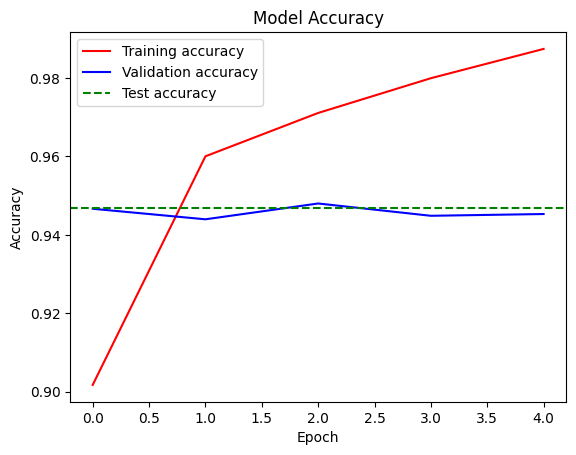

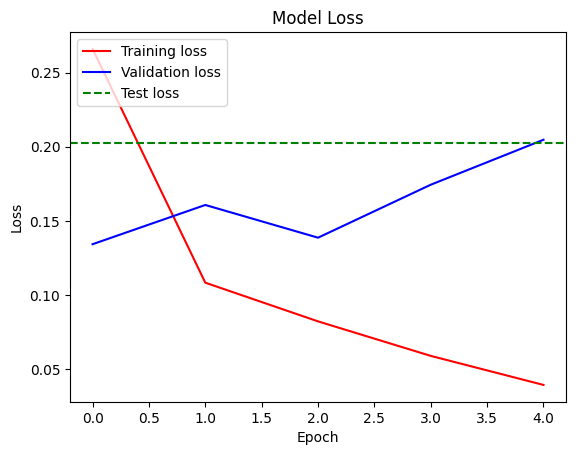

In [6]:
# Here we define the model parameters before the training process 
num_layers = 4
d_model = 128
num_heads = 8
d_ff = 512
input_vocab_size = tokenizer.vocab_size + 2 
maximum_position_encoding = 512
rate = 0.1
num_classes = df['class'].nunique()

# Here we create the TransformerClassifier model
model = TransformerClassifier(num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, rate, num_classes)

# Here we define the loss function, optimizer, and metrics for the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Training the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=5)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)

# Plot training & validation accuracy values
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
